In [94]:
# import
import numpy as np
import random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [95]:
# create data
classA=np.concatenate((np.random.randn(10,2)*0.2+[1.5,0.5], np.random.randn(10,2)*0.2+[-1.5,0.5]))
classB=np.random.randn(20,2)*0.2+[0.0,-0.5]

inputs=np.concatenate((classA,classB))
targets=np.concatenate((np.ones(classA.shape[0]),-np.ones(classB.shape[0])))

N = inputs.shape[0] # Number of samples

# shuffle them
permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute,:]
targets = targets[permute]

In [130]:
def kernel_lin(x, y):
   z = np.dot(x.T, y)
   return z

def kernel_poly(x, y, p):
    z = (np.dot(x.T, y) + 1)**p
    return z
    
def kernel_rbf(x, y, sigma):
    norm_l2 = norm((x-y.T))
    z = np.exp(-((norm_l2**2)/(2*sigma**2)))
    return z

def zerofun(a):
    z = np.dot(a, targets)
    return z

# define stuff
C = 50       # punishment for slack
start = np.zeros(N)
B = [(0, C) for b in range(N)]
p = 1 # parameter for polynomial Kernel
sigma = 1 # parameter for rgb Kernel

# calc P matrix for objective 
#K = np.array([[kernel_lin(i, j) for i in inputs] for j in inputs])
K = np.array([[kernel_poly(i, j, p) for i in inputs] for j in inputs])
#K = np.array([[kernel_rbf(i, j, sigma) for i in inputs] for j in inputs])
T = np.array([[i*j for i in targets] for j in targets])
P = K*T
        

def objective(a):
    A = [[a_i*a_j for a_i in a] for a_j in a]
    z = 0.5*np.sum(A*P) - np.sum(a)
    return z


ret = minimize(objective, start, bounds=B, constraints={'type': 'eq', 'fun': zerofun})
all_alpha = ret['x']


# extract non-zero alphas, x_i & t_i
alpha = []
for i in range(len(all_alpha)):
    if all_alpha[i] > 10**(-5):
        alpha.append((all_alpha[i], inputs[i], targets[i]))

# find alpha for b calc
i = 0
while(alpha[i][0] <= 0 or alpha[i][0] > C):
    i = i + 1
alpha_b = alpha[i]

# find threshold b
X = all_alpha*targets
#b = np.sum(X*kernel_lin(alpha_b[1], inputs.T)) - alpha_b[2]
b = np.sum(X*kernel_poly(alpha_b[1], inputs.T, p)) - alpha_b[2]
#b = np.sum(all_alpha*targets*np.array([kernel_rbf(alpha_b[1], i,sigma) for i in inputs])) - alpha_b[2]

# indictor function
def indicator(x, y):
    point = np.array([x, y])
    #return np.sum(X*kernel_lin(point, inputs.T)) - b
    return np.sum(X*kernel_poly(point, inputs.T,p)) - b
    #return np.sum(all_alpha*targets*np.array([kernel_rbf(point, i, sigma) for i in inputs])) - b



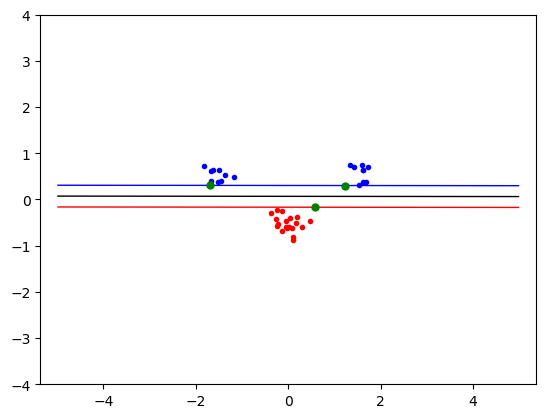

In [131]:
xgrid = np.linspace(-5,5)
ygrid = np.linspace(-4,4)
grid = np.array([[indicator(x,y) for x in xgrid] for y in ygrid])

# create plot
plt.plot([p[0]for p in classA], [p[1]for p in classA],'b.')
plt.plot([p[0]for p in classB], [p[1]for p in classB],'r.')
plt.contour(xgrid,ygrid,grid,(-1.0,0.0,1.0),colors=('red','black','blue'),linewidths=(1,1,1))
plt.plot([i[1][0] for i in alpha], [i[1][1] for i in alpha], 'g.', markersize=10)
plt.axis('equal') # Force same scale on both axes
plt.savefig('svmplot.pdf') # Save a copy in a file
plt.show() # Show the plot on the screen

